Import all the required libraries.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

Print the TensorFlow version.

In [2]:
tf.__version__

'1.2.1'

Initialize the filter size and number of filters for both the convolutional layers.
Also, intialize the total number of nodes in the convolutional layer.

In [3]:
filter_size1 = 5          
num_filters1 = 16         

filter_size2 = 5          
num_filters2 = 36         

fc_size = 128             

Download and extract the training and testing images and labels sets from the MNIST dataset.

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


Display the sizes of the labels in each sets of the MNIST data.

In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


Calculate the class number for each label in the test set.

In [6]:
data.test.cls = np.argmax(data.test.labels, axis=1)

Initialize the dimensions of the image and we know that image size is 28 pixels for the MNIST images.

In [7]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 10

Create a method for displaying images.

In [8]:
def display_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 16
    
    fig, axes = plt.subplots(4, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

Plot few sample images.

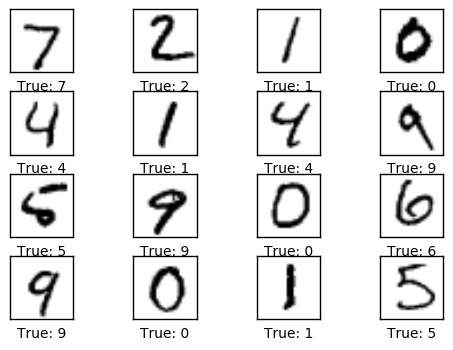

In [9]:
images = data.test.images[0:16]
cls_true = data.test.cls[0:16]
display_images(images=images, cls_true=cls_true)

Create a new TensorFlow variables and initialize with the random values.

In [10]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [11]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

Create a convolutional layer method in the computational graph for TensorFlow by using, input, number of channels, filter size, number of filters. Input is assumed as four-dimensional tensor with these (Image number, X-axis of image, Y-axis of image, Channels of each image) dimensions. 

In [12]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True):  

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    
    layer = tf.nn.conv2d(input=input,filter=weights,strides=[1, 1, 1, 1],padding='SAME')
    layer += biases

  
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],padding='SAME')

    layer = tf.nn.relu(layer)

    return layer, weights

The output of the convolutional layer is a 4-dimension tensor and so need to reduce to lower dimension. Create a flatter layer method which reduce the 4-dimension tensor to 2-dimension so that the output can be used as input to the fully connected layer. Reshape the input from [image number, image height, image width, number of channels] to [image number, number of features] where the number of features is the product of image height, image width and number of channels.

In [13]:
def flatten_layer(layer):
    
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

Now create a fully connected layer method with input of 2-dimension tensor and calculate the layers by calculating the mathematical formula weight*input + biases after creating weights and biases.

In [14]:
def new_fc_layer(input,num_inputs,num_outputs,use_relu=True):

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

Define a placeholder variable for the input image.

In [15]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

Reshape the variable x to 4-dimension tensor because the input to the convolutional layer is 4-dimension tensor.

In [16]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Similarly, create a placeholder variable for true labels.

In [17]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

Also, create placeholder varible for the class number using argmax method.

In [18]:
y_true_cls = tf.argmax(y_true, dimension=1)

Now create a first convolutional layer by calling convolutional layer method as defined before and use pooling to down sample the image resolution by 2.

In [19]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,num_input_channels=num_channels,filter_size=filter_size1,
                                            num_filters=num_filters1,use_pooling=True)

Verify the dimension or shape of the tensor from the output of the first convolutional layer.

In [20]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

Create a second convolutional layer by again calling the convolutional layer method in which the output from the 1st convolutional layer is given as input to the second convolutional layer.

In [21]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,num_input_channels=num_filters1,filter_size=filter_size2,
                                            num_filters=num_filters2, use_pooling=True)

Verify the dimension or shape of the tensor from the output of the second convolutional layer.

In [22]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

Flatten the output of the 2nd convolutional layer from 4-dimensional tensor to 2-dimensional tensor.

In [23]:
layer_flat, num_features = flatten_layer(layer_conv2)

Verify the dimension of the flattened layer and calculate the number of features.

In [24]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [25]:
num_features

1764

Implement the fully connected layer by passing flattened layer as input and also pass number of features.

In [26]:
layer_fc1 = new_fc_layer(input=layer_flat,num_inputs=num_features,num_outputs=fc_size,use_relu=True)

In [27]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

Now add another fully connected layer that outputs vectors each of length 10.

In [28]:
layer_fc2 = new_fc_layer(input=layer_fc1,num_inputs=fc_size,num_outputs=num_classes,use_relu=False)

In [29]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

Normalize the output of the second fully connected layer by using softmax method.

In [30]:
y_pred = tf.nn.softmax(layer_fc2)

Also, calculate the class number which is the index of the largest element.

In [31]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Now, calculate the cross-entropy for the output of the second fully connected layer using softmax.

In [32]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,labels=y_true)

find the average of cross-entropy of all the image classification. 

In [33]:
cost = tf.reduce_mean(cross_entropy)

Create an AdamOptimizer which is an advanced form of Gradient Descent.

In [34]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

Create a boolean vector where the prediction class equals the true class.

In [35]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

Calculate the classification accuracy.

In [36]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Create a TensorFlow session to execute a TensorFlow graph.

In [37]:
session = tf.Session()

In [38]:
session.run(tf.global_variables_initializer())

Select certain batch of input images.

In [39]:
train_batch_size = 64

Create an optimize method to optimize the variables of the network layers and for each iteration, a new batch of data is selected from the training data.

In [40]:
total_iterations = 0

def optimize(num_iterations):
    global total_iterations

    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        feed_dict_train = {x: x_batch,y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)

        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))

    total_iterations += num_iterations
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))


Create method to plot images from the test set that are wrongly classified.

In [41]:
def display_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    display_images(images=images[0:16],cls_true=cls_true[0:16],cls_pred=cls_pred[0:16])

Create a method to implement the classification accuracy for a test-set. Here, the test-set is splitted in to small number of batches.

In [42]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False):
    num_test = len(data.test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = data.test.images[i:j, :]
        labels = data.test.labels[i:j, :]
        feed_dict = {x: images,y_true: labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j
    cls_true = data.test.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    
    if show_example_errors:
        print("Errors:")
        display_errors(cls_pred=cls_pred, correct=correct)
    

In [43]:
print_test_accuracy()

Accuracy on Test-Set: 9.8% (983 / 10000)


In [44]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  15.6%
Time usage: 0:00:00


In [45]:
print_test_accuracy()

Accuracy on Test-Set: 9.9% (988 / 10000)


In [46]:
optimize(num_iterations=99) 

Time usage: 0:00:09


Accuracy on Test-Set: 62.6% (6265 / 10000)
Errors:


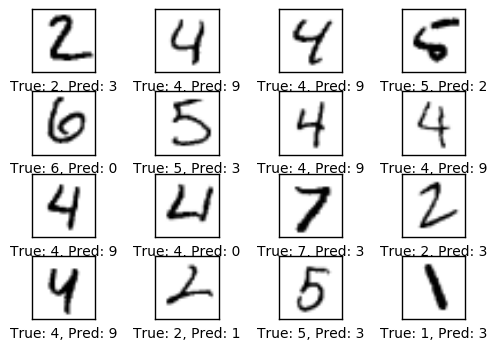

In [47]:
print_test_accuracy(show_example_errors=True)

In [48]:
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:    101, Training Accuracy:  64.1%
Optimization Iteration:    201, Training Accuracy:  81.2%
Optimization Iteration:    301, Training Accuracy:  81.2%
Optimization Iteration:    401, Training Accuracy:  85.9%
Optimization Iteration:    501, Training Accuracy:  98.4%
Optimization Iteration:    601, Training Accuracy:  90.6%
Optimization Iteration:    701, Training Accuracy:  90.6%
Optimization Iteration:    801, Training Accuracy:  95.3%
Optimization Iteration:    901, Training Accuracy:  96.9%
Time usage: 0:01:17


Accuracy on Test-Set: 93.1% (9312 / 10000)
Errors:


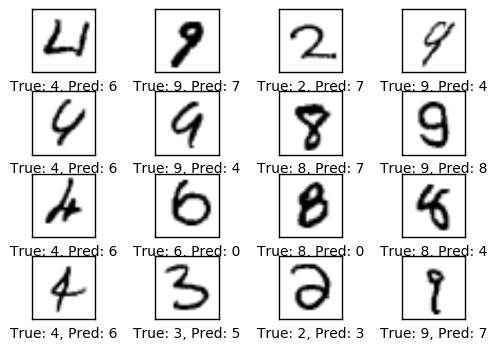

In [49]:
print_test_accuracy(show_example_errors=True)

In [50]:
optimize(num_iterations=4500) 

Optimization Iteration:   1001, Training Accuracy:  85.9%
Optimization Iteration:   1101, Training Accuracy:  90.6%
Optimization Iteration:   1201, Training Accuracy:  98.4%
Optimization Iteration:   1301, Training Accuracy:  96.9%
Optimization Iteration:   1401, Training Accuracy:  95.3%
Optimization Iteration:   1501, Training Accuracy:  98.4%
Optimization Iteration:   1601, Training Accuracy:  90.6%
Optimization Iteration:   1701, Training Accuracy:  96.9%
Optimization Iteration:   1801, Training Accuracy:  93.8%
Optimization Iteration:   1901, Training Accuracy:  96.9%
Optimization Iteration:   2001, Training Accuracy: 100.0%
Optimization Iteration:   2101, Training Accuracy:  98.4%
Optimization Iteration:   2201, Training Accuracy: 100.0%
Optimization Iteration:   2301, Training Accuracy:  95.3%
Optimization Iteration:   2401, Training Accuracy:  98.4%
Optimization Iteration:   2501, Training Accuracy:  93.8%
Optimization Iteration:   2601, Training Accuracy:  96.9%
Optimization I

Accuracy on Test-Set: 98.3% (9832 / 10000)
Errors:


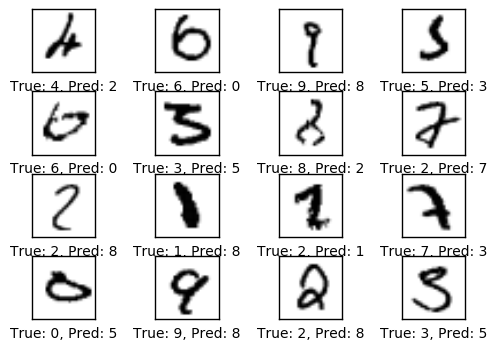

In [51]:
print_test_accuracy(show_example_errors=True)